# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=50,
        fold=5,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_15-24-28/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191905 [00:00<?, ?it/s]

  0%|          | 0/53056 [00:00<?, ?it/s]

  0%|          | 0/21691 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.5150 | MulticlassF1Score=0.1762
Batch-30 : CrossEntropyLoss=2.5094 | MulticlassF1Score=0.2186
Batch-45 : CrossEntropyLoss=2.4835 | MulticlassF1Score=0.2315
Batch-60 : CrossEntropyLoss=2.4554 | MulticlassF1Score=0.2380
Batch-75 : CrossEntropyLoss=2.4901 | MulticlassF1Score=0.2432
Batch-90 : CrossEntropyLoss=2.5089 | MulticlassF1Score=0.2454
Batch-105: CrossEntropyLoss=2.4716 | MulticlassF1Score=0.2508
Batch-120: CrossEntropyLoss=2.4637 | MulticlassF1Score=0.2582
Batch-135: CrossEntropyLoss=2.4238 | MulticlassF1Score=0.2781
Batch-150: CrossEntropyLoss=2.3758 | MulticlassF1Score=0.3048
Batch-165: CrossEntropyLoss=2.3773 | MulticlassF1Score=0.3300
Batch-180: CrossEntropyLoss=2.3856 | MulticlassF1Score=0.3513
Batch-195: CrossEntropyLoss=2.3791 | MulticlassF1Score=0.3691
Batch-210: CrossEntropyLoss=2.3804 | MulticlassF1Score=0.3850
Batch-225: CrossEntropyLoss=2.3690 | MulticlassF1Score=0.3997
Batch-226: CrossEntropyLoss=2.3651 | MulticlassF1Score=0.4005

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3857 | MulticlassF1Score=0.5853
Batch-30 : CrossEntropyLoss=2.3623 | MulticlassF1Score=0.5875
Batch-45 : CrossEntropyLoss=2.3744 | MulticlassF1Score=0.5885
Batch-60 : CrossEntropyLoss=2.3670 | MulticlassF1Score=0.5885
Batch-63 : CrossEntropyLoss=2.3793 | MulticlassF1Score=0.5894

Training   : Mean CrossEntropyLoss = 2.4440 | Mean MulticlassF1Score = 0.2783
Validation : Mean CrossEntropyLoss = 2.3746 | Mean MulticlassF1Score = 0.5872

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3850 | MulticlassF1Score=0.6010
Batch-30 : CrossEntropyLoss=2.3735 | MulticlassF1Score=0.5968
Batch-45 : CrossEntropyLoss=2.3578 | MulticlassF1Score=0.5975
Batch-60 : CrossEntropyLoss=2.3400 | MulticlassF1Score=0.6167
Batch-75 : CrossEntropyLoss=2.3446 | MulticlassF1Score=0.6259
Batch-90 : CrossEntropyLoss=2.3364 | MulticlassF1Score=0.6341
Batch-105: CrossEntropyLoss=2.3461 | MulticlassF1Score=0.6412
Batch-120: CrossEntropyLoss=2.3398 | MulticlassF1Score=0.6466
Batch-135: CrossEntropyLoss=2.3455 | MulticlassF1Score=0.6499
Batch-150: CrossEntropyLoss=2.3359 | MulticlassF1Score=0.6538
Batch-165: CrossEntropyLoss=2.3272 | MulticlassF1Score=0.6610
Batch-180: CrossEntropyLoss=2.3321 | MulticlassF1Score=0.6653
Batch-195: CrossEntropyLoss=2.3350 | MulticlassF1Score=0.6690
Batch-210: CrossEntropyLoss=2.3275 | MulticlassF1Score=0.6728
Batch-225: CrossEntropyLoss=2.3385 | MulticlassF1Score=0.6761
Batch-226: CrossEntropyLoss=2.3343 | MulticlassF1Score=0.6761

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3480 | MulticlassF1Score=0.7055
Batch-30 : CrossEntropyLoss=2.3251 | MulticlassF1Score=0.7162
Batch-45 : CrossEntropyLoss=2.3293 | MulticlassF1Score=0.7179
Batch-60 : CrossEntropyLoss=2.3351 | MulticlassF1Score=0.7181
Batch-63 : CrossEntropyLoss=2.3417 | MulticlassF1Score=0.7177

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3491 | Mean MulticlassF1Score = 0.6381
Validation : Mean CrossEntropyLoss = 2.3351 | Mean MulticlassF1Score = 0.7127

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3210 | MulticlassF1Score=0.7427
Batch-30 : CrossEntropyLoss=2.3097 | MulticlassF1Score=0.7586
Batch-45 : CrossEntropyLoss=2.3126 | MulticlassF1Score=0.7678
Batch-60 : CrossEntropyLoss=2.3184 | MulticlassF1Score=0.7718
Batch-75 : CrossEntropyLoss=2.3077 | MulticlassF1Score=0.7743
Batch-90 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7788
Batch-105: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.7803
Batch-120: CrossEntropyLoss=2.3081 | MulticlassF1Score=0.7825
Batch-135: CrossEntropyLoss=2.3108 | MulticlassF1Score=0.7850
Batch-150: CrossEntropyLoss=2.3115 | MulticlassF1Score=0.7869
Batch-165: CrossEntropyLoss=2.3112 | MulticlassF1Score=0.7883
Batch-180: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.7900
Batch-195: CrossEntropyLoss=2.3053 | MulticlassF1Score=0.7916
Batch-210: CrossEntropyLoss=2.3170 | MulticlassF1Score=0.7925
Batch-225: CrossEntropyLoss=2.3074 | MulticlassF1Score=0.7936
Batch-226: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.7936

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3311 | MulticlassF1Score=0.7913
Batch-30 : CrossEntropyLoss=2.2983 | MulticlassF1Score=0.7978
Batch-45 : CrossEntropyLoss=2.3114 | MulticlassF1Score=0.7998
Batch-60 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8001
Batch-63 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8002

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3124 | Mean MulticlassF1Score = 0.7764
Validation : Mean CrossEntropyLoss = 2.3097 | Mean MulticlassF1Score = 0.7980

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3074 | MulticlassF1Score=0.8000
Batch-30 : CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8046
Batch-45 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8074
Batch-60 : CrossEntropyLoss=2.3087 | MulticlassF1Score=0.8075
Batch-75 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8064
Batch-90 : CrossEntropyLoss=2.3059 | MulticlassF1Score=0.8066
Batch-105: CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8076
Batch-120: CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8074
Batch-135: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8078
Batch-150: CrossEntropyLoss=2.3176 | MulticlassF1Score=0.8081
Batch-165: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8079
Batch-180: CrossEntropyLoss=2.3066 | MulticlassF1Score=0.8079
Batch-195: CrossEntropyLoss=2.3160 | MulticlassF1Score=0.8081
Batch-210: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8083
Batch-225: CrossEntropyLoss=2.3056 | MulticlassF1Score=0.8081
Batch-226: CrossEntropyLoss=2.3020 | MulticlassF1Score=0.8082

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8036
Batch-30 : CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8048
Batch-45 : CrossEntropyLoss=2.3119 | MulticlassF1Score=0.8027
Batch-60 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8035
Batch-63 : CrossEntropyLoss=2.3136 | MulticlassF1Score=0.8036

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3073 | Mean MulticlassF1Score = 0.8068
Validation : Mean CrossEntropyLoss = 2.3084 | Mean MulticlassF1Score = 0.8046

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3139 | MulticlassF1Score=0.8126
Batch-30 : CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8134
Batch-45 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8138
Batch-60 : CrossEntropyLoss=2.3069 | MulticlassF1Score=0.8130
Batch-75 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8115
Batch-90 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8119
Batch-105: CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8107
Batch-120: CrossEntropyLoss=2.3048 | MulticlassF1Score=0.8107
Batch-135: CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8114
Batch-150: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8126
Batch-165: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8142
Batch-180: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8150
Batch-195: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8157
Batch-210: CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8168
Batch-225: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8176
Batch-226: CrossEntropyLoss=2.3027 | MulticlassF1Score=0.8176

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8215
Batch-30 : CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8250
Batch-45 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8233
Batch-60 : CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8240
Batch-63 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3042 | Mean MulticlassF1Score = 0.8130
Validation : Mean CrossEntropyLoss = 2.3020 | Mean MulticlassF1Score = 0.8224

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8329
Batch-30 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8350
Batch-45 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8337
Batch-60 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8324
Batch-75 : CrossEntropyLoss=2.2971 | MulticlassF1Score=0.8320
Batch-90 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8317
Batch-105: CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8307
Batch-120: CrossEntropyLoss=2.3000 | MulticlassF1Score=0.8314
Batch-135: CrossEntropyLoss=2.3052 | MulticlassF1Score=0.8315
Batch-150: CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8319
Batch-165: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8332
Batch-180: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8342
Batch-195: CrossEntropyLoss=2.3018 | MulticlassF1Score=0.8351
Batch-210: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8362
Batch-225: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8371
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8371

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8380
Batch-30 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8404
Batch-45 : CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8406
Batch-60 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8393
Batch-63 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8399

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2983 | Mean MulticlassF1Score = 0.8329
Validation : Mean CrossEntropyLoss = 2.2972 | Mean MulticlassF1Score = 0.8406

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8511
Batch-30 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8498
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8487
Batch-60 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8486
Batch-75 : CrossEntropyLoss=2.2930 | MulticlassF1Score=0.8495
Batch-90 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8501
Batch-105: CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8507
Batch-120: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8503
Batch-135: CrossEntropyLoss=2.2964 | MulticlassF1Score=0.8506
Batch-150: CrossEntropyLoss=2.2942 | MulticlassF1Score=0.8506
Batch-165: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8507
Batch-180: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8509
Batch-195: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8509
Batch-210: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8503
Batch-225: CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8501
Batch-226: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8500

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8430
Batch-30 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8428
Batch-45 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8432
Batch-60 : CrossEntropyLoss=2.2950 | MulticlassF1Score=0.8423
Batch-63 : CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8429

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2943 | Mean MulticlassF1Score = 0.8500
Validation : Mean CrossEntropyLoss = 2.2961 | Mean MulticlassF1Score = 0.8428

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8411
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8444
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8481
Batch-60 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8498
Batch-75 : CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8502
Batch-90 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8500
Batch-105: CrossEntropyLoss=2.2915 | MulticlassF1Score=0.8497
Batch-120: CrossEntropyLoss=2.2947 | MulticlassF1Score=0.8502
Batch-135: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8504
Batch-150: CrossEntropyLoss=2.2922 | MulticlassF1Score=0.8509
Batch-165: CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8514
Batch-180: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8514
Batch-195: CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8515
Batch-210: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8517
Batch-225: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8519
Batch-226: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8520

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8393
Batch-30 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8437
Batch-45 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8436
Batch-60 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8426
Batch-63 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8429

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2935 | Mean MulticlassF1Score = 0.8493
Validation : Mean CrossEntropyLoss = 2.2960 | Mean MulticlassF1Score = 0.8435

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8546
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8577
Batch-45 : CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8550
Batch-60 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8540
Batch-75 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8550
Batch-90 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8541
Batch-105: CrossEntropyLoss=2.3083 | MulticlassF1Score=0.8543
Batch-120: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8540
Batch-135: CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8537
Batch-150: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8543
Batch-165: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8540
Batch-180: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8539
Batch-195: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8536
Batch-210: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8530
Batch-225: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8529
Batch-226: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8531

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8463
Batch-30 : CrossEntropyLoss=2.2926 | MulticlassF1Score=0.8462
Batch-45 : CrossEntropyLoss=2.2944 | MulticlassF1Score=0.8453
Batch-60 : CrossEntropyLoss=2.2919 | MulticlassF1Score=0.8440
Batch-63 : CrossEntropyLoss=2.3121 | MulticlassF1Score=0.8438

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2931 | Mean MulticlassF1Score = 0.8547
Validation : Mean CrossEntropyLoss = 2.2958 | Mean MulticlassF1Score = 0.8456

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8573
Batch-30 : CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8577
Batch-45 : CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8581
Batch-60 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8575
Batch-75 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8577
Batch-90 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8565
Batch-105: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8556
Batch-120: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8556
Batch-135: CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8561
Batch-150: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8576
Batch-165: CrossEntropyLoss=2.2895 | MulticlassF1Score=0.8582
Batch-180: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8598
Batch-195: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8608
Batch-210: CrossEntropyLoss=2.2742 | MulticlassF1Score=0.8625
Batch-225: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8639
Batch-226: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8640

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2911 | MulticlassF1Score=0.8731
Batch-30 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8732
Batch-45 : CrossEntropyLoss=2.2852 | MulticlassF1Score=0.8740
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8734
Batch-63 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8738

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2899 | Mean MulticlassF1Score = 0.8582
Validation : Mean CrossEntropyLoss = 2.2870 | Mean MulticlassF1Score = 0.8723

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8855
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8832
Batch-45 : CrossEntropyLoss=2.2860 | MulticlassF1Score=0.8823
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8829
Batch-75 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8822
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8827
Batch-105: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8824
Batch-120: CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8828
Batch-135: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8837
Batch-150: CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8837
Batch-165: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8840
Batch-180: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8837
Batch-195: CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8838
Batch-210: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8841
Batch-225: CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8842
Batch-226: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8843

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8726
Batch-30 : CrossEntropyLoss=2.2900 | MulticlassF1Score=0.8754
Batch-45 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8751
Batch-60 : CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8759
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8754

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2836 | Mean MulticlassF1Score = 0.8834
Validation : Mean CrossEntropyLoss = 2.2862 | Mean MulticlassF1Score = 0.8739

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8886
Batch-30 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8882
Batch-45 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8886
Batch-60 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8894
Batch-75 : CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8901
Batch-90 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8902
Batch-105: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8906
Batch-120: CrossEntropyLoss=2.2912 | MulticlassF1Score=0.8896
Batch-135: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8893
Batch-150: CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8889
Batch-165: CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8883
Batch-180: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8879
Batch-195: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8881
Batch-210: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8879
Batch-225: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8878
Batch-226: CrossEntropyLoss=2.2861 | MulticlassF1Score=0.8878

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8802
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8796
Batch-45 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8781
Batch-60 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8780
Batch-63 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8781

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2825 | Mean MulticlassF1Score = 0.8890
Validation : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8790

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8874
Batch-30 : CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8893
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8901
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8889
Batch-75 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8895
Batch-90 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8894
Batch-105: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8891
Batch-120: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8889
Batch-135: CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8894
Batch-150: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8896
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8899
Batch-180: CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8901
Batch-195: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8902
Batch-210: CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8901
Batch-225: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8901
Batch-226: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8901

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8823
Batch-30 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8785
Batch-45 : CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8790
Batch-60 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8786
Batch-63 : CrossEntropyLoss=2.2813 | MulticlassF1Score=0.8781

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8898
Validation : Mean CrossEntropyLoss = 2.2852 | Mean MulticlassF1Score = 0.8806

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8926
Batch-30 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8909
Batch-45 : CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8920
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8919
Batch-75 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8918
Batch-90 : CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8922
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8920
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8915
Batch-135: CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8921
Batch-150: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.8920
Batch-165: CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8916
Batch-180: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8919
Batch-195: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8919
Batch-210: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8918
Batch-225: CrossEntropyLoss=2.2805 | MulticlassF1Score=0.8914
Batch-226: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.8914

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8816
Batch-30 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8796
Batch-45 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8782
Batch-60 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8783
Batch-63 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8786

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2812 | Mean MulticlassF1Score = 0.8919
Validation : Mean CrossEntropyLoss = 2.2851 | Mean MulticlassF1Score = 0.8793

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8897
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8906
Batch-45 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8915
Batch-60 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.8911
Batch-75 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8914
Batch-90 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.8918
Batch-105: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8923
Batch-120: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8934
Batch-135: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8931
Batch-150: CrossEntropyLoss=2.2854 | MulticlassF1Score=0.8930
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.8930
Batch-180: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8934
Batch-195: CrossEntropyLoss=2.2744 | MulticlassF1Score=0.8931
Batch-210: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8929
Batch-225: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8927
Batch-226: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.8928

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8834
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8797
Batch-45 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8787
Batch-60 : CrossEntropyLoss=2.2870 | MulticlassF1Score=0.8786
Batch-63 : CrossEntropyLoss=2.2932 | MulticlassF1Score=0.8786

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2808 | Mean MulticlassF1Score = 0.8919
Validation : Mean CrossEntropyLoss = 2.2849 | Mean MulticlassF1Score = 0.8804

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.8924
Batch-30 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.8949
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.8948
Batch-60 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8939
Batch-75 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8939
Batch-90 : CrossEntropyLoss=2.2905 | MulticlassF1Score=0.8938
Batch-105: CrossEntropyLoss=2.2776 | MulticlassF1Score=0.8936
Batch-120: CrossEntropyLoss=2.2889 | MulticlassF1Score=0.8935
Batch-135: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8934
Batch-150: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8937
Batch-165: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.8935
Batch-180: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8938
Batch-195: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8935
Batch-210: CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8936
Batch-225: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8938
Batch-226: CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8938

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2873 | MulticlassF1Score=0.8811
Batch-30 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8813
Batch-45 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8793
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8799
Batch-63 : CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8792

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2804 | Mean MulticlassF1Score = 0.8936
Validation : Mean CrossEntropyLoss = 2.2848 | Mean MulticlassF1Score = 0.8802

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8965
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8929
Batch-45 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.8933
Batch-60 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8920
Batch-75 : CrossEntropyLoss=2.2804 | MulticlassF1Score=0.8927
Batch-90 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8936
Batch-105: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8933
Batch-120: CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8937
Batch-135: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8935
Batch-150: CrossEntropyLoss=2.2841 | MulticlassF1Score=0.8934
Batch-165: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8935
Batch-180: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.8937
Batch-195: CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8938
Batch-210: CrossEntropyLoss=2.2838 | MulticlassF1Score=0.8940
Batch-225: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.8943
Batch-226: CrossEntropyLoss=2.2845 | MulticlassF1Score=0.8943

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8786
Batch-30 : CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8785
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8793
Batch-60 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8794
Batch-63 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8797

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2802 | Mean MulticlassF1Score = 0.8939
Validation : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8800

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8963
Batch-30 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8947
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.8936
Batch-60 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8945
Batch-75 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.8943
Batch-90 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8942
Batch-105: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8946
Batch-120: CrossEntropyLoss=2.2829 | MulticlassF1Score=0.8956
Batch-135: CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8949
Batch-150: CrossEntropyLoss=2.2850 | MulticlassF1Score=0.8952
Batch-165: CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8956
Batch-180: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8954
Batch-195: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8951
Batch-210: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8950
Batch-225: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8953
Batch-226: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8951

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2846 | MulticlassF1Score=0.8788
Batch-30 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8802
Batch-45 : CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8811
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8799
Batch-63 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8804

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2799 | Mean MulticlassF1Score = 0.8949
Validation : Mean CrossEntropyLoss = 2.2844 | Mean MulticlassF1Score = 0.8800

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8888
Batch-30 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.8925
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8937
Batch-60 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.8933
Batch-75 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8944
Batch-90 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8949
Batch-105: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8950
Batch-120: CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8955
Batch-135: CrossEntropyLoss=2.2774 | MulticlassF1Score=0.8955
Batch-150: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.8956
Batch-165: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8958
Batch-180: CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8962
Batch-195: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8958
Batch-210: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8960
Batch-225: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8962
Batch-226: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8961

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8827
Batch-30 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8782
Batch-45 : CrossEntropyLoss=2.2790 | MulticlassF1Score=0.8798
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8799
Batch-63 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.8800

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2796 | Mean MulticlassF1Score = 0.8943
Validation : Mean CrossEntropyLoss = 2.2846 | Mean MulticlassF1Score = 0.8804

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.8955
Batch-30 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8974
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8990
Batch-60 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8983
Batch-75 : CrossEntropyLoss=2.2848 | MulticlassF1Score=0.8980
Batch-90 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8979
Batch-105: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8977
Batch-120: CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8971
Batch-135: CrossEntropyLoss=2.2799 | MulticlassF1Score=0.8968
Batch-150: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8965
Batch-165: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.8967
Batch-180: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8961
Batch-195: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8963
Batch-210: CrossEntropyLoss=2.2830 | MulticlassF1Score=0.8964
Batch-225: CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8968
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8968

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8812
Batch-30 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8831
Batch-45 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8839
Batch-60 : CrossEntropyLoss=2.2874 | MulticlassF1Score=0.8840
Batch-63 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8837

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2794 | Mean MulticlassF1Score = 0.8969
Validation : Mean CrossEntropyLoss = 2.2834 | Mean MulticlassF1Score = 0.8839

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9007
Batch-30 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9048
Batch-45 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9038
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9045
Batch-75 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9038
Batch-90 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9042
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9049
Batch-120: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9047
Batch-135: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.9043
Batch-150: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9037
Batch-165: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.9031
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9029
Batch-195: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9027
Batch-210: CrossEntropyLoss=2.2846 | MulticlassF1Score=0.9027
Batch-225: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9027
Batch-226: CrossEntropyLoss=2.2747 | MulticlassF1Score=0.9027

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8951
Batch-30 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8918
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8906
Batch-60 : CrossEntropyLoss=2.2827 | MulticlassF1Score=0.8892
Batch-63 : CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8891

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2777 | Mean MulticlassF1Score = 0.9035
Validation : Mean CrossEntropyLoss = 2.2818 | Mean MulticlassF1Score = 0.8921

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9080
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9099
Batch-45 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9086
Batch-60 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9081
Batch-75 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9077
Batch-90 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9070
Batch-105: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9067
Batch-120: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9059
Batch-135: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.9056
Batch-150: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9056
Batch-165: CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9057
Batch-180: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9056
Batch-195: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9055
Batch-210: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9057
Batch-225: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9060
Batch-226: CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9060

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2798 | MulticlassF1Score=0.8920
Batch-30 : CrossEntropyLoss=2.2832 | MulticlassF1Score=0.8909
Batch-45 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8900
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8900
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8895

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2767 | Mean MulticlassF1Score = 0.9070
Validation : Mean CrossEntropyLoss = 2.2816 | Mean MulticlassF1Score = 0.8908

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9083
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9088
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9083
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9082
Batch-75 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9075
Batch-90 : CrossEntropyLoss=2.2859 | MulticlassF1Score=0.9070
Batch-105: CrossEntropyLoss=2.2806 | MulticlassF1Score=0.9069
Batch-120: CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9065
Batch-135: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9063
Batch-150: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9066
Batch-165: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9069
Batch-180: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9066
Batch-195: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9068
Batch-210: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9069
Batch-225: CrossEntropyLoss=2.2781 | MulticlassF1Score=0.9070
Batch-226: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.9070

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8917
Batch-30 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8911
Batch-45 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.8902
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8900
Batch-63 : CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8903

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2762 | Mean MulticlassF1Score = 0.9072
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8909

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9043
Batch-30 : CrossEntropyLoss=2.2812 | MulticlassF1Score=0.9074
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9076
Batch-60 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9080
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9076
Batch-90 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9076
Batch-105: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9080
Batch-120: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9085
Batch-135: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9091
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9090
Batch-165: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9091
Batch-180: CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9090
Batch-195: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9086
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9088
Batch-225: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9083
Batch-226: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9084

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8919
Batch-30 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.8909
Batch-45 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8896
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8899
Batch-63 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8900

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2758 | Mean MulticlassF1Score = 0.9079
Validation : Mean CrossEntropyLoss = 2.2814 | Mean MulticlassF1Score = 0.8914

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9108
Batch-30 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9111
Batch-45 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.9092
Batch-60 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9095
Batch-75 : CrossEntropyLoss=2.2821 | MulticlassF1Score=0.9095
Batch-90 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9097
Batch-105: CrossEntropyLoss=2.2789 | MulticlassF1Score=0.9094
Batch-120: CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9096
Batch-135: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9096
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9096
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9096
Batch-180: CrossEntropyLoss=2.2791 | MulticlassF1Score=0.9094
Batch-195: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.9092
Batch-210: CrossEntropyLoss=2.2803 | MulticlassF1Score=0.9089
Batch-225: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9093
Batch-226: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9093

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8957
Batch-30 : CrossEntropyLoss=2.2823 | MulticlassF1Score=0.9003
Batch-45 : CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8990
Batch-60 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8980
Batch-63 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8975

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2755 | Mean MulticlassF1Score = 0.9097
Validation : Mean CrossEntropyLoss = 2.2791 | Mean MulticlassF1Score = 0.8972

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9161
Batch-30 : CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9180
Batch-45 : CrossEntropyLoss=2.2753 | MulticlassF1Score=0.9172
Batch-60 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9179
Batch-75 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9174
Batch-90 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9171
Batch-105: CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9170
Batch-120: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9177
Batch-135: CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9173
Batch-150: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9172
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9171
Batch-180: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9173
Batch-195: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9174
Batch-210: CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9173
Batch-225: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9175
Batch-226: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9175

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8991
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9008
Batch-45 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9009
Batch-60 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8987
Batch-63 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8982

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2729 | Mean MulticlassF1Score = 0.9172
Validation : Mean CrossEntropyLoss = 2.2789 | Mean MulticlassF1Score = 0.8995

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9157
Batch-30 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9162
Batch-45 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9168
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9175
Batch-75 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9182
Batch-90 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9181
Batch-105: CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9179
Batch-120: CrossEntropyLoss=2.2851 | MulticlassF1Score=0.9179
Batch-135: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9178
Batch-150: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9177
Batch-165: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9179
Batch-180: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9182
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9181
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9183
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9184
Batch-226: CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9185

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2810 | MulticlassF1Score=0.8998
Batch-30 : CrossEntropyLoss=2.2793 | MulticlassF1Score=0.8988
Batch-45 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.8984
Batch-60 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.8985
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.8986

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9178
Validation : Mean CrossEntropyLoss = 2.2787 | Mean MulticlassF1Score = 0.8993

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9152
Batch-30 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9174
Batch-75 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9182
Batch-90 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9190
Batch-105: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9183
Batch-120: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9182
Batch-135: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9186
Batch-150: CrossEntropyLoss=2.2757 | MulticlassF1Score=0.9186
Batch-165: CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9188
Batch-180: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9190
Batch-195: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9188
Batch-210: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9189
Batch-225: CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9188
Batch-226: CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9188

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8972
Batch-30 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8987
Batch-45 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8974
Batch-60 : CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8976
Batch-63 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8982

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2725 | Mean MulticlassF1Score = 0.9181
Validation : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.8990

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9179
Batch-30 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9170
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9178
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9171
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9173
Batch-90 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9180
Batch-105: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9186
Batch-120: CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9192
Batch-135: CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9191
Batch-150: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9190
Batch-165: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9191
Batch-180: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9194
Batch-195: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9194
Batch-210: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9193
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9193
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.9192

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.8968
Batch-30 : CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9002
Batch-45 : CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8998
Batch-60 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8983
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.8989

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2724 | Mean MulticlassF1Score = 0.9186
Validation : Mean CrossEntropyLoss = 2.2786 | Mean MulticlassF1Score = 0.8990

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9197
Batch-30 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9212
Batch-45 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9198
Batch-75 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9198
Batch-90 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9201
Batch-105: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9199
Batch-120: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9197
Batch-135: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9203
Batch-150: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9205
Batch-165: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9203
Batch-180: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9198
Batch-195: CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9197
Batch-210: CrossEntropyLoss=2.2767 | MulticlassF1Score=0.9194
Batch-225: CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9194
Batch-226: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9194

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2830 | MulticlassF1Score=0.9030
Batch-30 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.8964
Batch-45 : CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8998
Batch-60 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8977
Batch-63 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8980

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9199
Validation : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.9001

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9188
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9175
Batch-45 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9184
Batch-60 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9179
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9177
Batch-90 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9192
Batch-105: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9220
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9242
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9258
Batch-150: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9276
Batch-165: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9292
Batch-180: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9302
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9311
Batch-210: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9320
Batch-225: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9331
Batch-226: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9331

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9262
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9236
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9234
Batch-60 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9238
Batch-63 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9240

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2683 | Mean MulticlassF1Score = 0.9240
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9239

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9465
Batch-75 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9462
Batch-90 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9462
Batch-105: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9464
Batch-120: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9456
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9453
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9454
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9456
Batch-210: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9456
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9458
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9458

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9269
Batch-30 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9270
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9257
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9261
Batch-63 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9263

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9457
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9266

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9456
Batch-60 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9461
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9468
Batch-90 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9476
Batch-105: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9477
Batch-135: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9478
Batch-150: CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9474
Batch-165: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9475
Batch-180: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9469
Batch-195: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9472
Batch-210: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9469
Batch-225: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9469
Batch-226: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9469

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9328
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9320
Batch-45 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9286
Batch-60 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9287
Batch-63 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9472
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9307

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9479
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9488
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9492
Batch-90 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9477
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9475
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9476
Batch-150: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9478
Batch-165: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9476
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9478
Batch-195: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9478
Batch-210: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9478
Batch-225: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9479
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9479

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9282
Batch-45 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9276
Batch-60 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9476
Validation : Mean CrossEntropyLoss = 2.2697 | Mean MulticlassF1Score = 0.9279

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9499
Batch-30 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9482
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9477
Batch-90 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9479
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9483
Batch-120: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9486
Batch-135: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9482
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9482
Batch-165: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9485
Batch-180: CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9484
Batch-195: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9484
Batch-210: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9485
Batch-225: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9484
Batch-226: CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2772 | MulticlassF1Score=0.9274
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9281
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9484
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9271

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9527
Batch-30 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9499
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9486
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9479
Batch-75 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9475
Batch-90 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9481
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9482
Batch-120: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9482
Batch-135: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9485
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9488
Batch-165: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9487
Batch-180: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9486
Batch-195: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9484
Batch-210: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9484
Batch-225: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9487
Batch-226: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9487

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9296
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9292
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9278
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9272

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9491
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9289

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9486
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9492
Batch-60 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9491
Batch-75 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9489
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9489
Batch-105: CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9490
Batch-120: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9488
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9489
Batch-150: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9488
Batch-165: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9491
Batch-180: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9489
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9486
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9484
Batch-226: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9484

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2795 | MulticlassF1Score=0.9236
Batch-30 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9271

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9491
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9273
Patience = 1/50❗

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9449
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9482
Batch-75 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9486
Batch-90 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9491
Batch-105: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9491
Batch-120: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9492
Batch-135: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9493
Batch-150: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9492
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9492
Batch-180: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9490
Batch-195: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9489
Batch-210: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9488
Batch-225: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9487
Batch-226: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9486

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9239
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9279
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9270
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9273
Batch-63 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9275

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9486
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9247

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9484
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9492
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9489
Batch-90 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9487
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9490
Batch-120: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9494
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9492
Batch-150: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9493
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9495
Batch-180: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9494
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9494
Batch-210: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9491
Batch-225: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9492
Batch-226: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9491

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9309
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9277
Batch-45 : CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9268
Batch-63 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2632 | Mean MulticlassF1Score = 0.9488
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9287

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9496
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9531
Batch-75 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9561
Batch-90 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9579
Batch-105: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9592
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9603
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9612
Batch-150: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9618
Batch-165: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9623
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9626
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9630
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9635
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9637
Batch-226: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9637

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9581
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9472

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9667
Batch-30 : CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9683
Batch-60 : CrossEntropyLoss=2.2520 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9686
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9684
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9691
Batch-165: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9689
Batch-195: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9688
Batch-226: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9688

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9468

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9698
Batch-30 : CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9705
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9701
Batch-105: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9697
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9698
Batch-150: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9695
Batch-210: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9693
Batch-225: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9450
Batch-45 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9466
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9466
Batch-63 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9467

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9456

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9695
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9700
Batch-45 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9701
Batch-60 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9697
Batch-90 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9697
Batch-105: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9696
Batch-120: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9697
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9698
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9697

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9467
Batch-63 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9456

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9702
Batch-30 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9709
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9709
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9707
Batch-75 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9708
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9708
Batch-120: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9700
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9699
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9698
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9697
Batch-195: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9699
Batch-210: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9700
Batch-226: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9700

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9469

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2567 | Mean MulticlassF1Score = 0.9702
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9472

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9701
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9695
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9696
Batch-75 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9702
Batch-90 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9705
Batch-105: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9705
Batch-120: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9704
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9707
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9707
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-180: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9705
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9706
Batch-210: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9703
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9447
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9454
Batch-60 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9457
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9461

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9703
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9461

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2525 | MulticlassF1Score=0.9711
Batch-45 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9719
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9712
Batch-90 : CrossEntropyLoss=2.2518 | MulticlassF1Score=0.9711
Batch-105: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9711
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9705
Batch-150: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9703
Batch-165: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9701
Batch-180: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9700
Batch-195: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9698
Batch-210: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9696
Batch-226: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9469
Batch-63 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9469

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9708
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9468
Patience = 2/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9707
Batch-30 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9704
Batch-45 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9706
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9706
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9709
Batch-90 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9702
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9705
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9702
Batch-150: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9701
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9702
Batch-195: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9701
Batch-210: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9700
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9702
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9701

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9469
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9473
Batch-63 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9471

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2566 | Mean MulticlassF1Score = 0.9704
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9475

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9718
Batch-30 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9697
Batch-45 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9698
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9700
Batch-90 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9703
Batch-105: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9703
Batch-120: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9707
Batch-135: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9709
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9710
Batch-165: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9710
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9709
Batch-195: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9710
Batch-210: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9710
Batch-225: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9710
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9710

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9497
Batch-30 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465
Batch-60 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2564 | Mean MulticlassF1Score = 0.9705
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9482

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9690
Batch-30 : CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-90 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9709
Batch-105: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9707
Batch-120: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9710
Batch-135: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9713
Batch-150: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9714
Batch-165: CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9713
Batch-180: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9714
Batch-210: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9714
Batch-225: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9714
Batch-226: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9709
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9473

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9710
Batch-30 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9715
Batch-45 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9720
Batch-60 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9715
Batch-75 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9714
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9715
Batch-105: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9715
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9716
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9716
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9713
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9714
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9713
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9713
Batch-210: CrossEntropyLoss=2.2515 | MulticlassF1Score=0.9713
Batch-225: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9713
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9713

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9495
Batch-30 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9503
Batch-45 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9489
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9482

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2562 | Mean MulticlassF1Score = 0.9716
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9489
Patience = 3/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2562
Best CrossEntropyLoss training    : 2.2635
Best MulticlassF1Score validation : 0.9709
Best MulticlassF1Score validation : 0.9473
Training duration                 : 1.9505 minutes.
Training date                     : 2022-10-19 10:57:07.690272+08:00


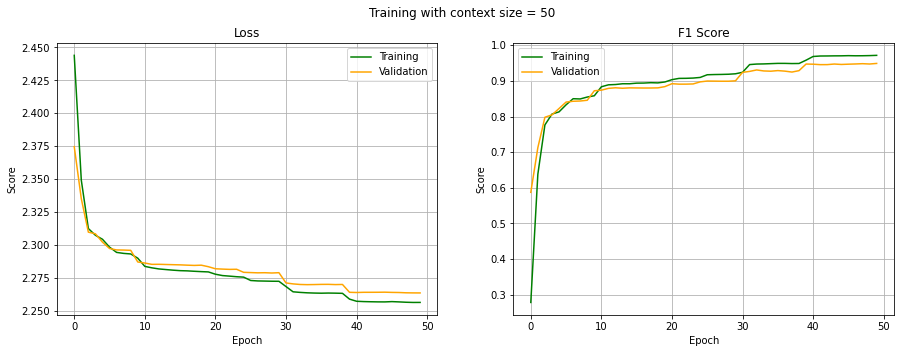

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9717, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9484, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9717, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9484, device='cuda:0'))

## Heatmap

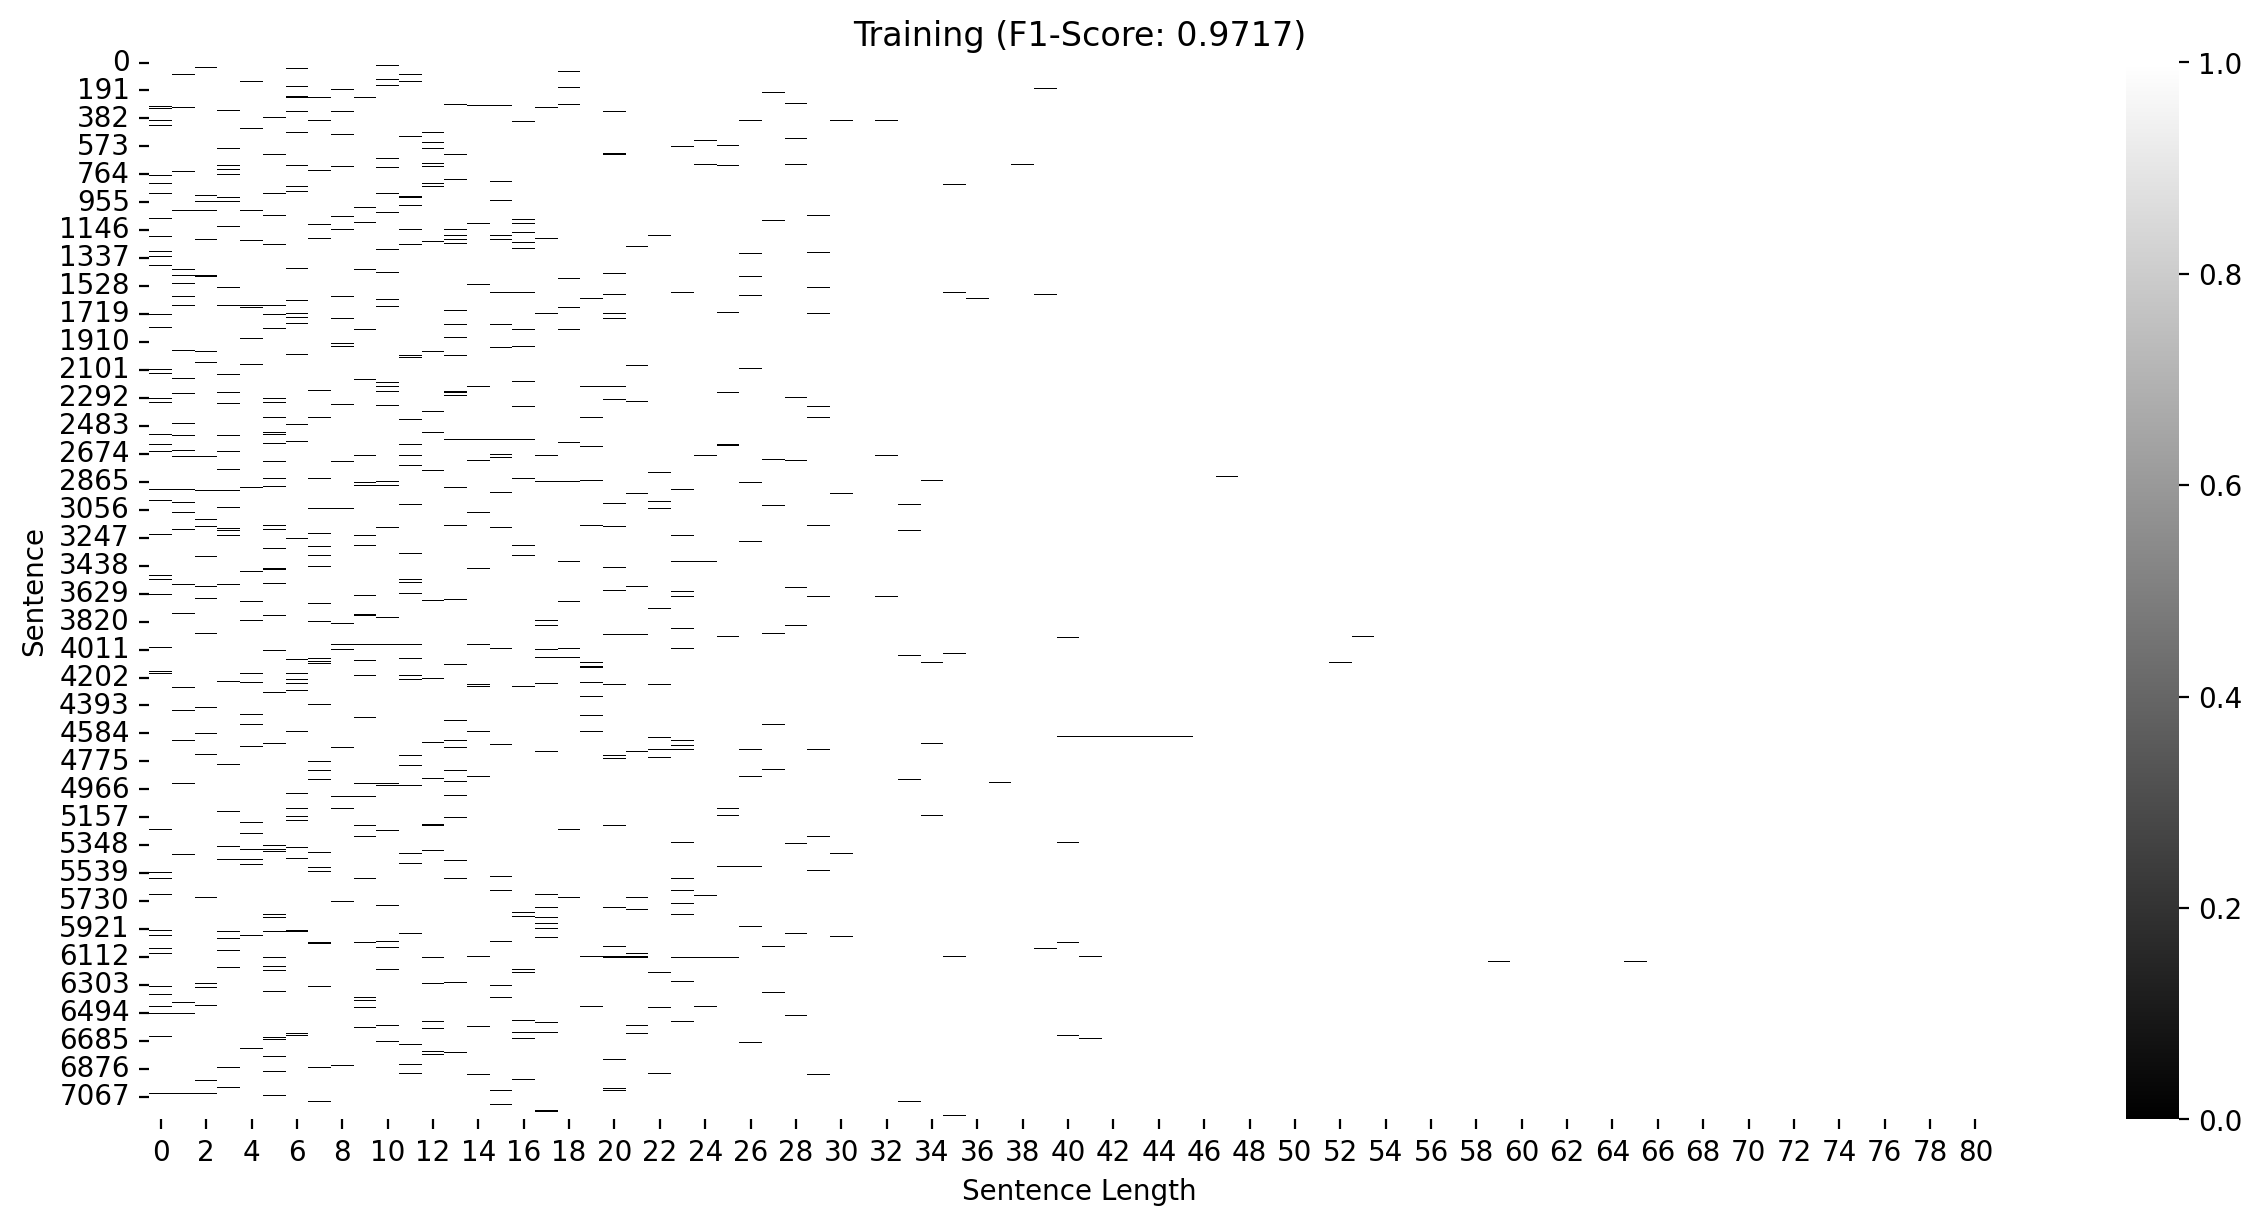

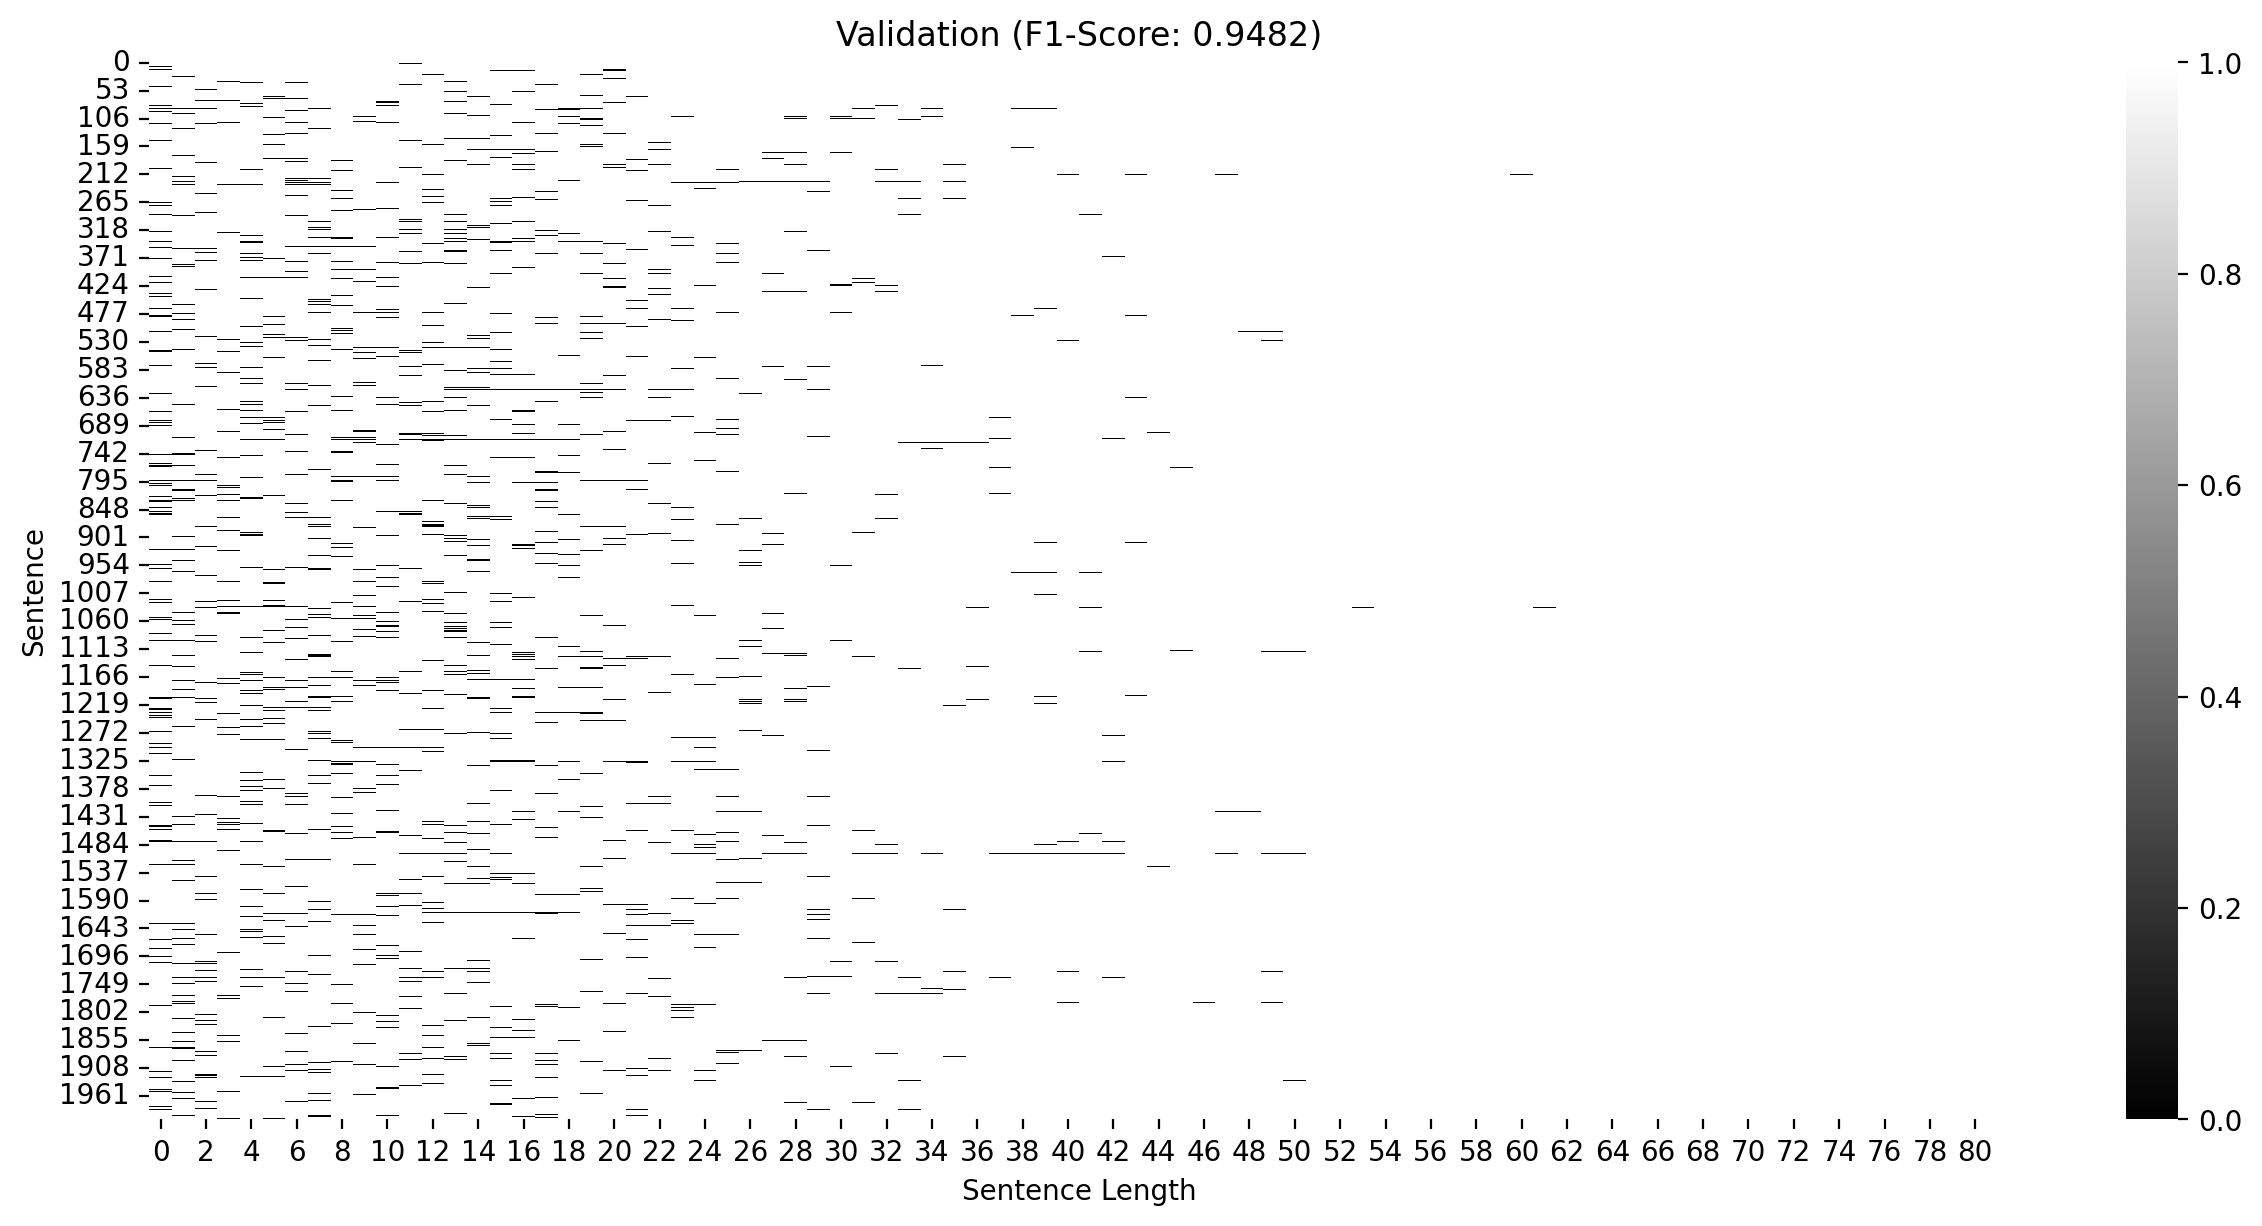

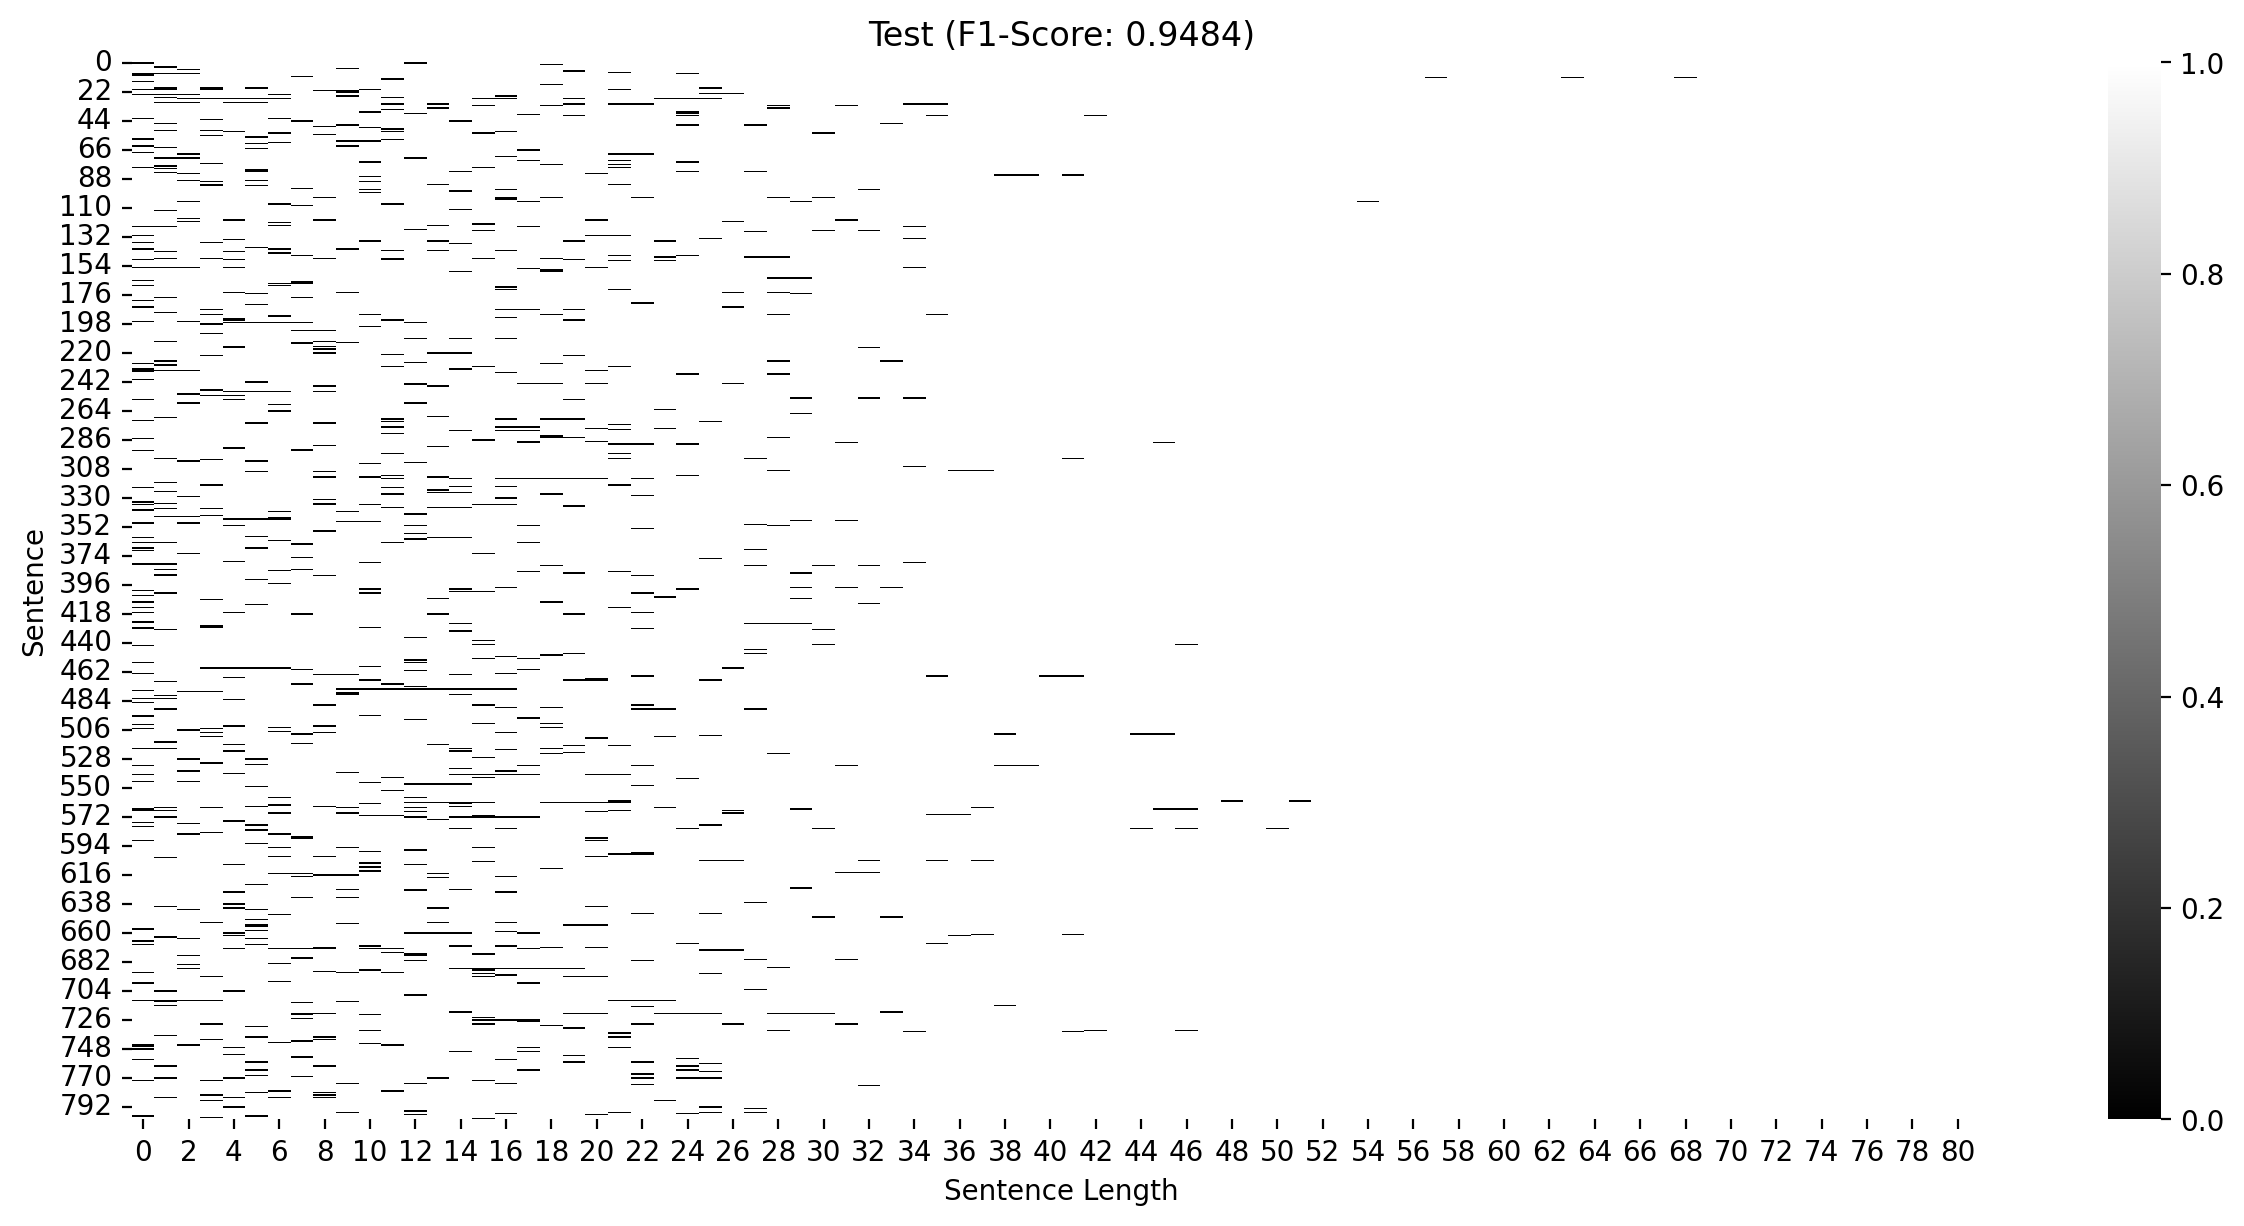

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


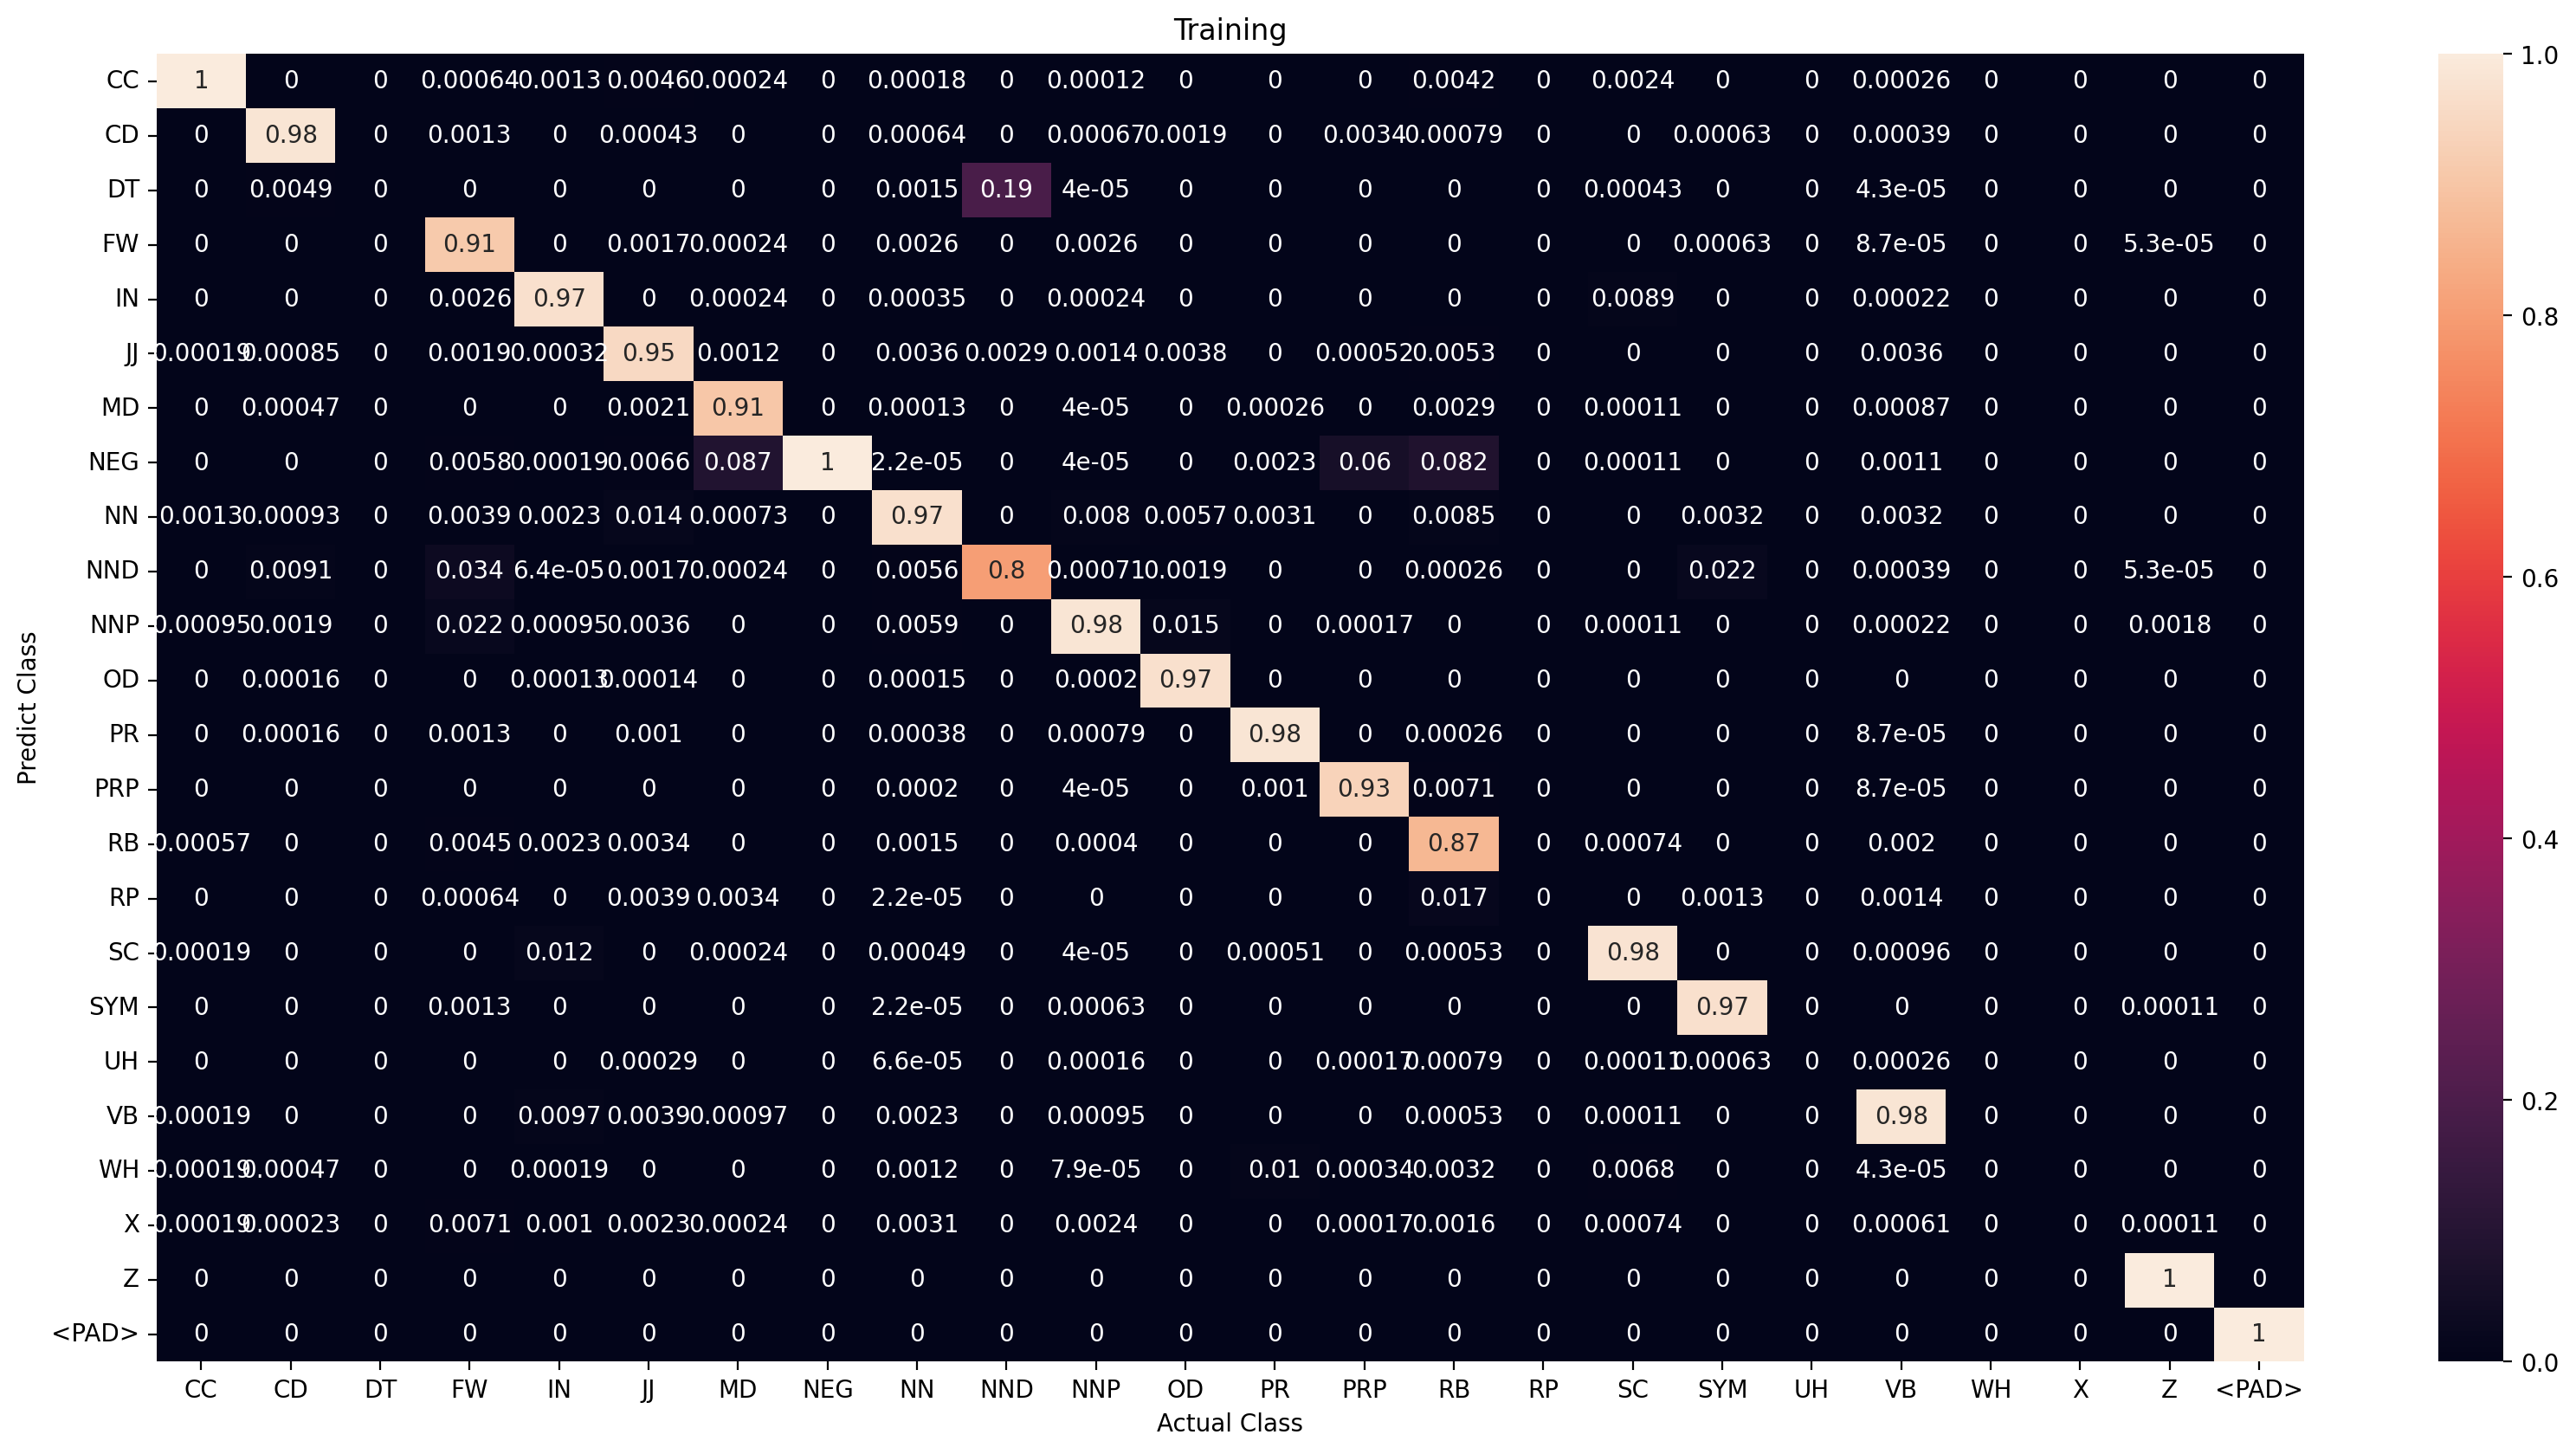

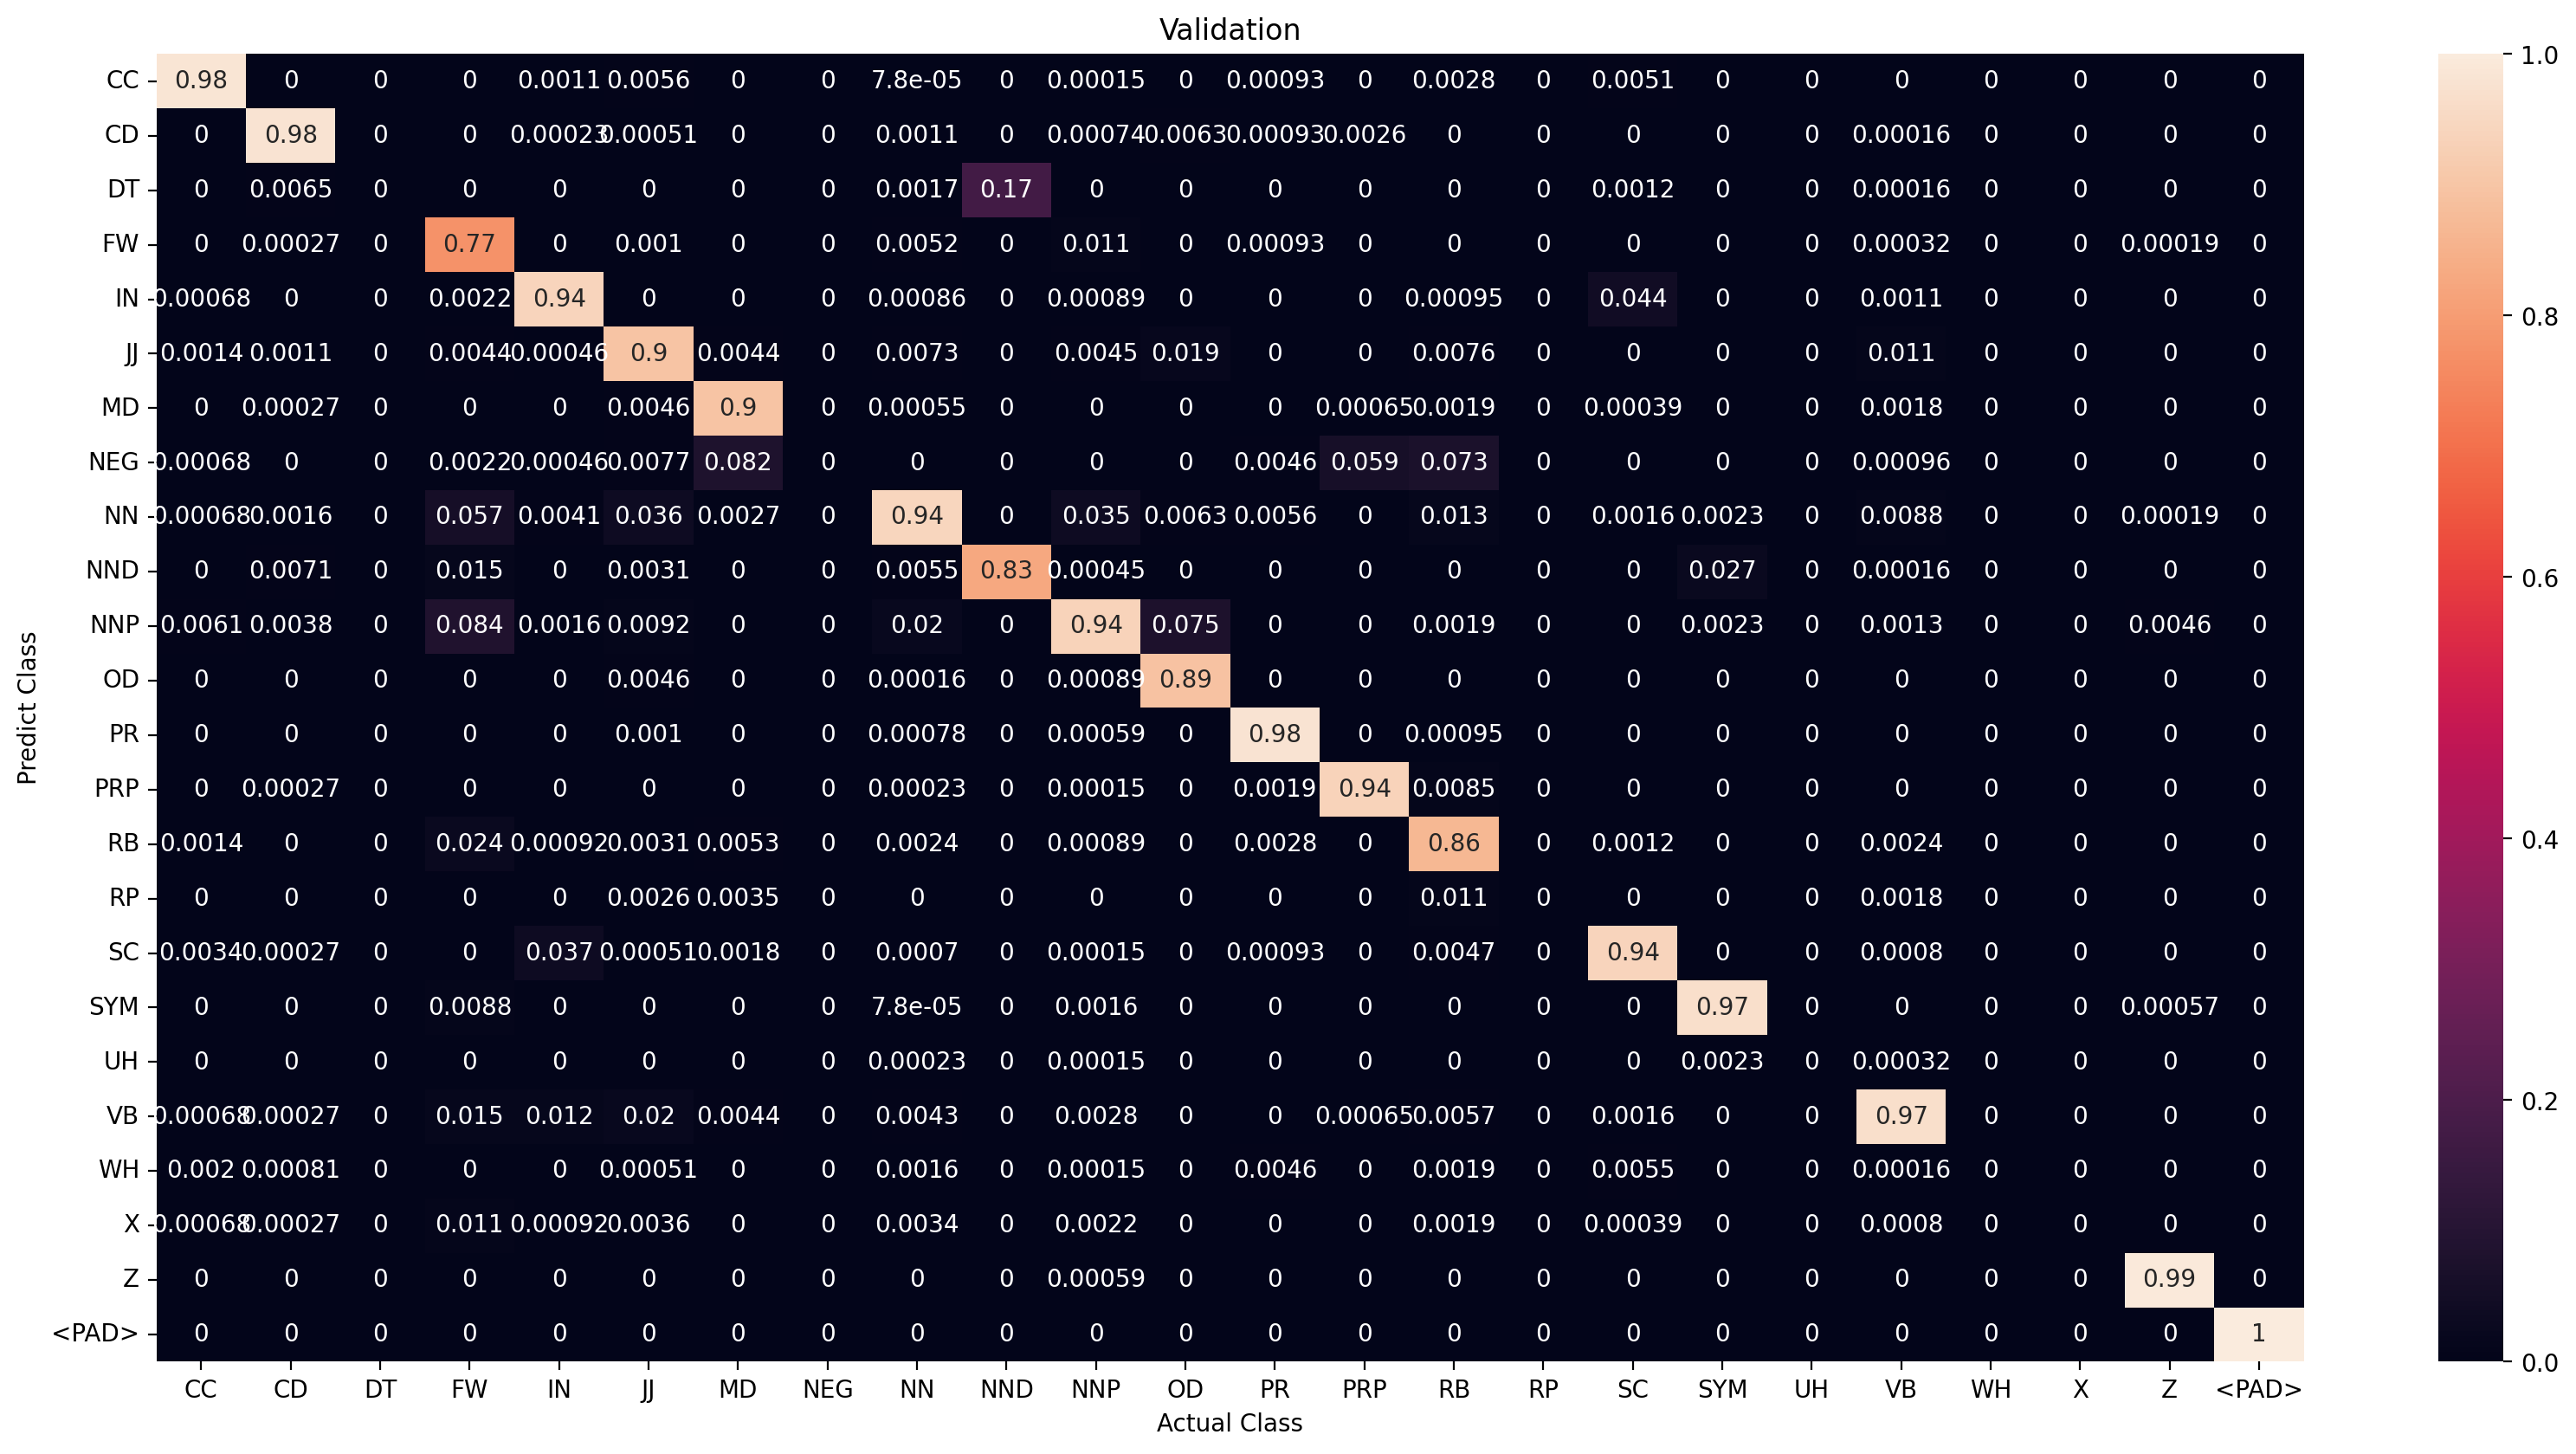

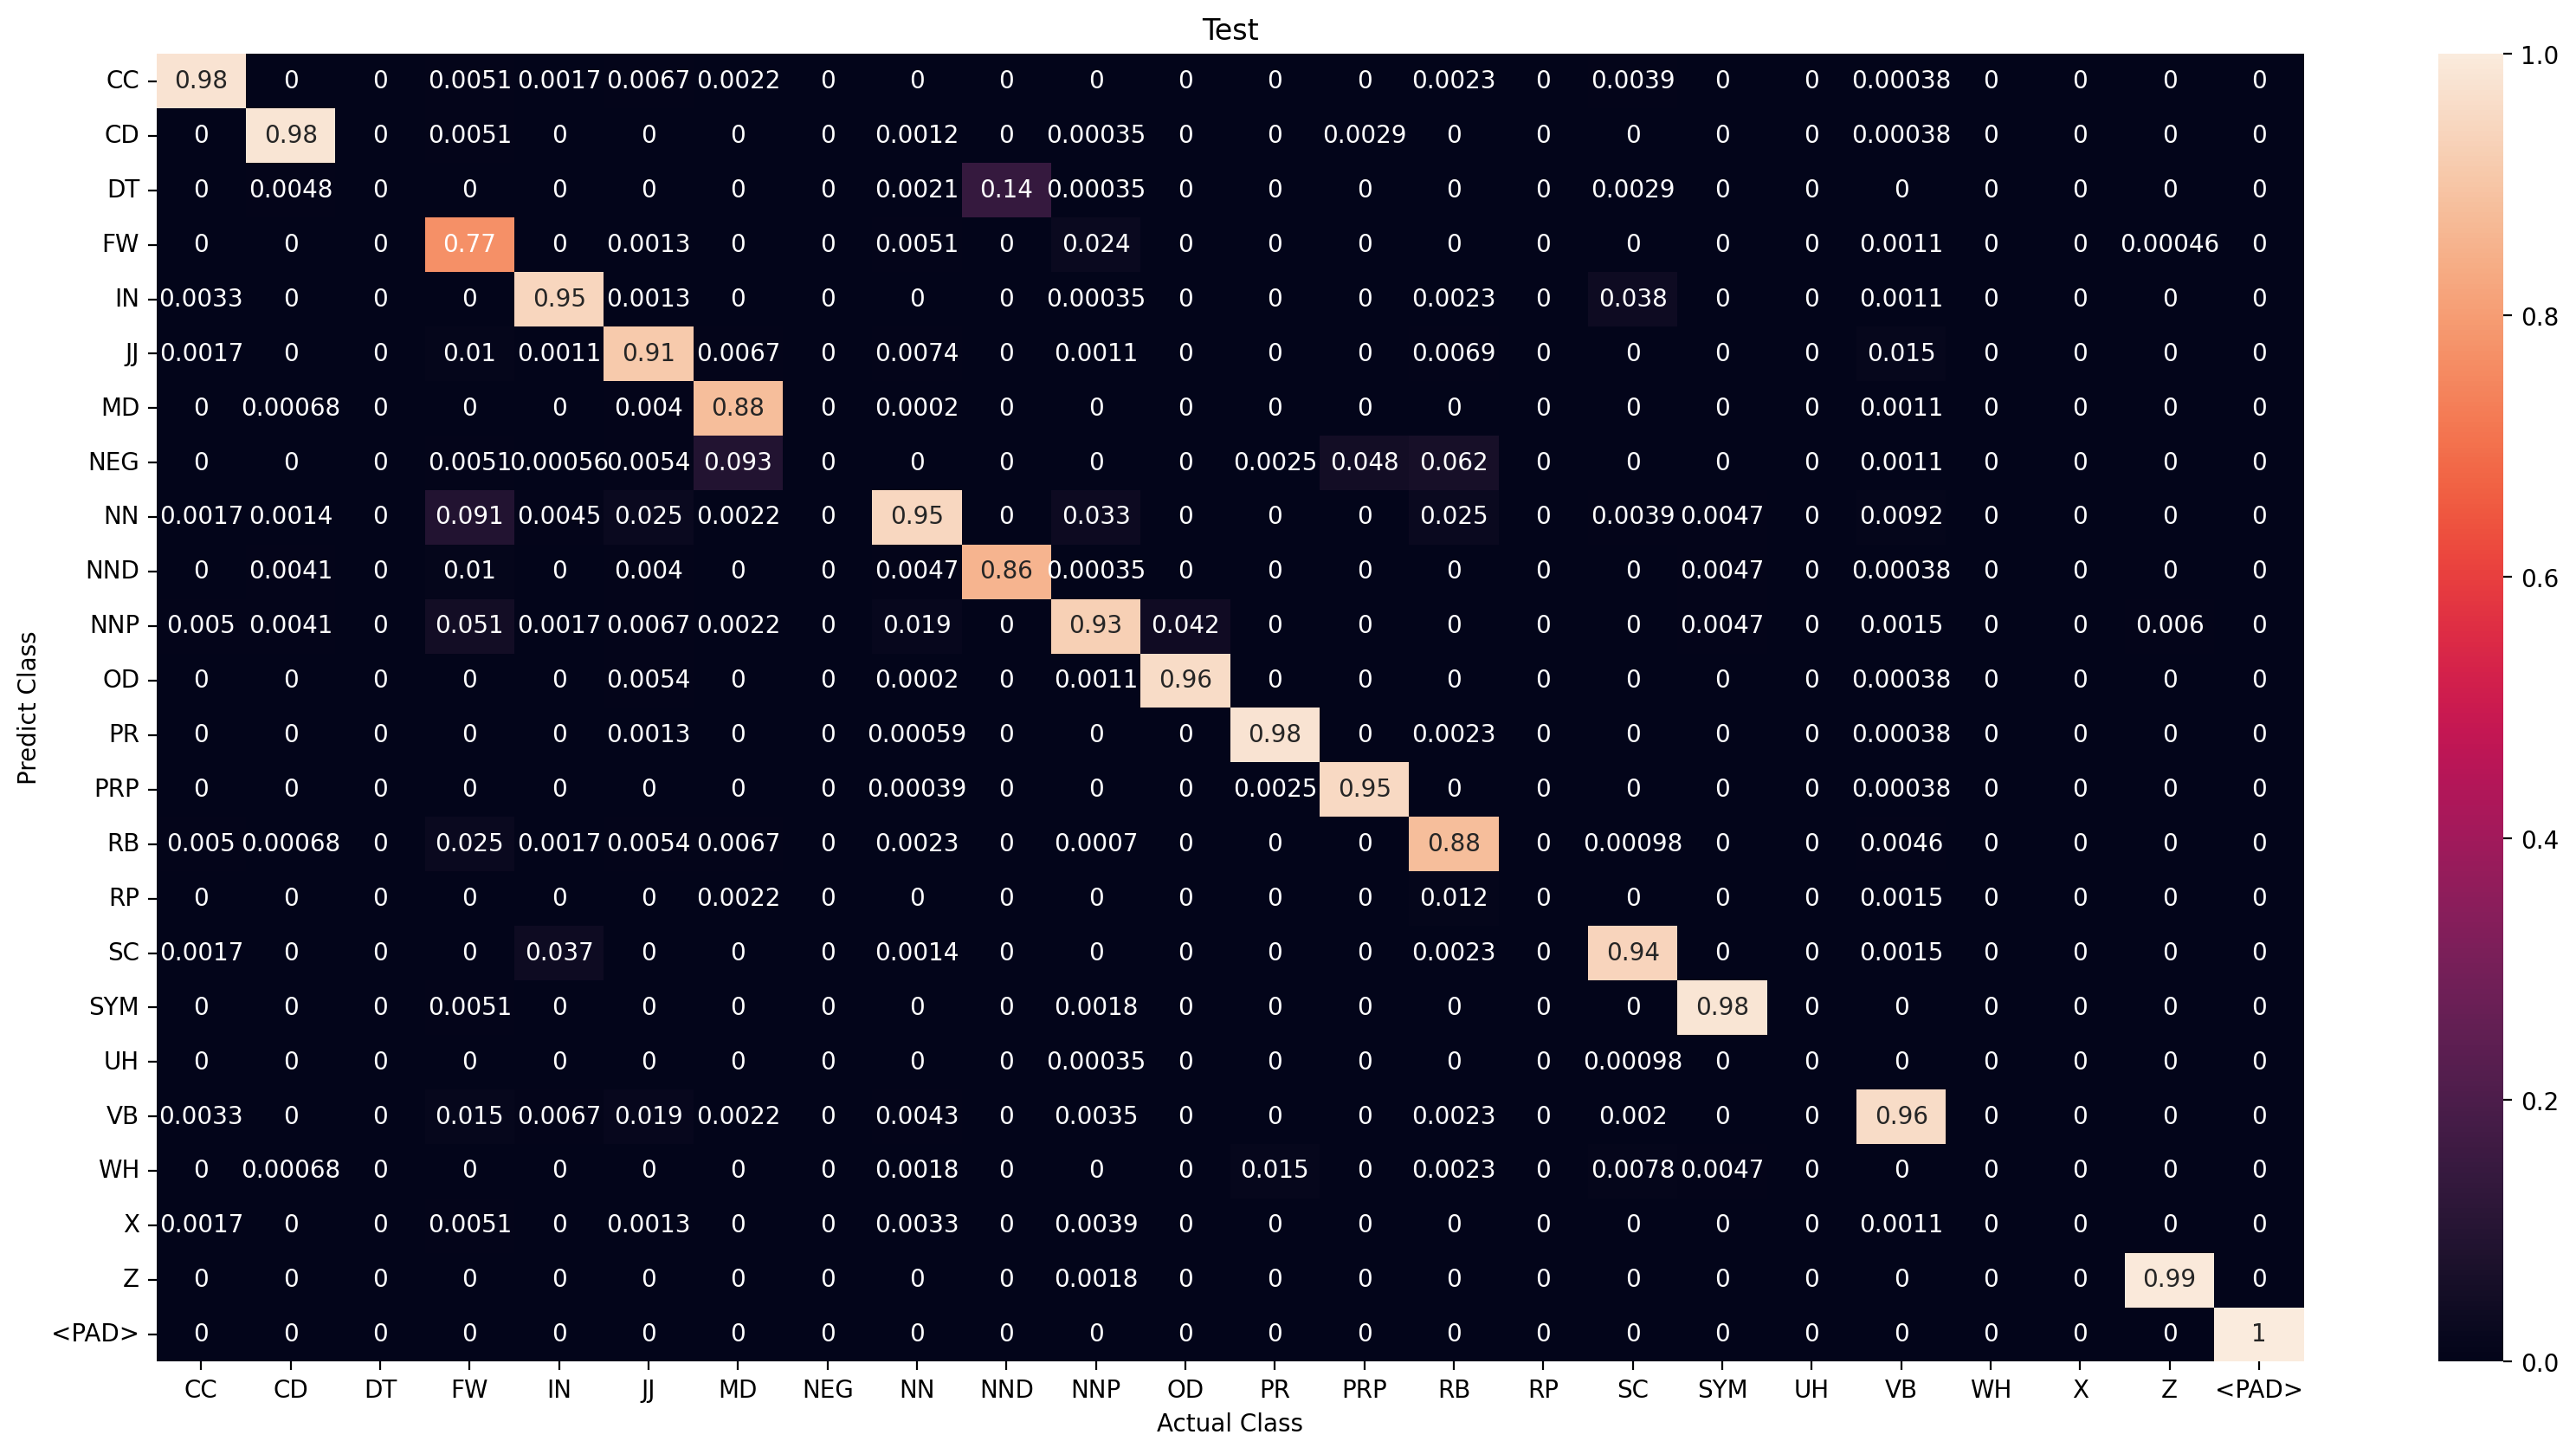

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5346   | CC    : 5236       | CC    : 110      |
| CD    : 12730  | CD    : 12645      | CD    : 85       |
| DT    : 269    | DT    : 0          | DT    : 269      |
| FW    : 1614   | FW    : 1416       | FW    : 198      |
| IN    : 15342  | IN    : 15226      | IN    : 116      |
| JJ    : 6981   | JJ    : 6647       | JJ    : 334      |
| MD    : 3799   | MD    : 3738       | MD    : 61       |
| NEG   : 1118   | NEG   : 1          | NEG   : 1117     |
| NN    : 44369  | NN    : 43878      | NN    : 491      |
| NND   : 1047   | NND   : 546        | NND   : 501      |
| NNP   : 25175  | NNP   : 24757      | NNP   : 418      |
| OD    : 524    | OD    : 507        | OD    : 17       |
| PR    : 3880   | PR    : 3829       | PR    : 51       |
| PRP   : 5471   | PRP   : 5428       | PRP   : 43       |
| RB    : 3477   | RB    : 3275       | RB    : 202      |
| RP    : 141    | RP    : 0          | RP    : 141     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8,  3, 12, 19,  8,  8,  8, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8,  3, 12, 19,  8,  8,  5, 16, 19,  4, 10,  8, 10,  0,  4,  1,  8,  8,
          8,  5,  4,  8, 10,  0, 10, 10, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([ True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11806
Correct prediction          : 11210
Wrong prediction            : 596
Percentage correct oov pred : 94.95171946467897

Validation
Number OOV token            : 3366
Correct prediction          : 3021
Wrong prediction            : 345
Percentage correct oov pred : 89.75044563279857

Test
Number OOV token            : 1390
Correct prediction          : 1241
Wrong prediction            : 149
Percentage correct oov pred : 89.28057553956835



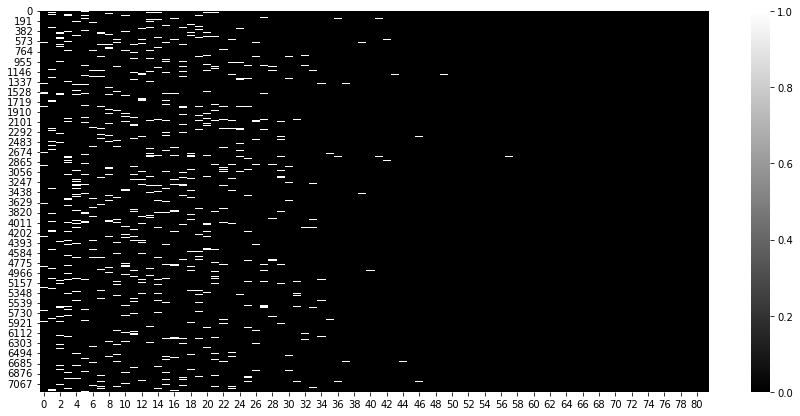

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

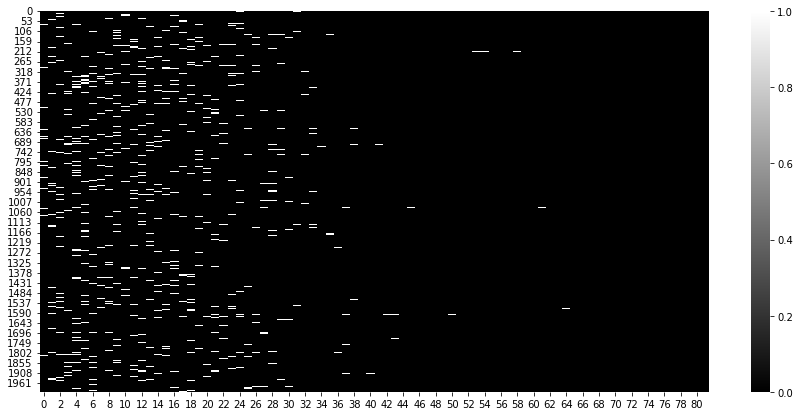

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

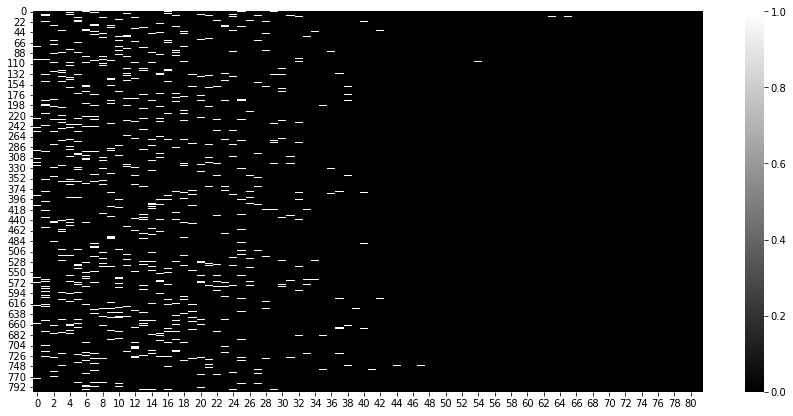

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);